# 4. Dimensionality Reduction & PCA

This notebook introduces dimensionality reduction using Principal Component Analysis (PCA).

## What is Dimensionality Reduction?

**Dimensionality reduction** means reducing features while keeping important information.

**Why?**
- Prevent overfitting (fewer features)
- Faster computation
- Remove noise
- Enable visualization

**Key insight**: Many datasets have redundant (correlated) features. We can capture most information with fewer dimensions.

## Setup

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve
from sklearn.decomposition import PCA

# Set random seed for reproducibility
np.random.seed(42)

## Load Data

In [7]:
# Load data
data = pd.read_csv('./data/abide2.tsv', sep='\t')

print(f"Dataset shape: {data.shape}")
print(f"Number of subjects: {data.shape[0]}")

# Extract all brain features (columns starting with 'fs')
X_all = data.filter(like='fs')
print(f"Number of brain features: {X_all.shape[1]}")

# Our target variable: age
y = data['age'].values

# Display first few rows
X_all.head()

Dataset shape: (1004, 1446)
Number of subjects: 1004
Number of brain features: 1440


,fsArea_L_V1_ROI,fsArea_L_MST_ROI,fsArea_L_V6_ROI,fsArea_L_V2_ROI,fsArea_L_V3_ROI,fsArea_L_V4_ROI,fsArea_L_V8_ROI,fsArea_L_4_ROI,fsArea_L_3b_ROI,fsArea_L_FEF_ROI,...,fsCT_R_p47r_ROI,fsCT_R_TGv_ROI,fsCT_R_MBelt_ROI,fsCT_R_LBelt_ROI,fsCT_R_A4_ROI,fsCT_R_STSva_ROI,fsCT_R_TE1m_ROI,fsCT_R_PI_ROI,fsCT_R_a32pr_ROI,fsCT_R_p24_ROI
0,2750.0,306.0,354.0,2123.0,1451.0,1128.0,269.0,1751.0,1338.0,632.0,...,3.362,2.827,2.777,2.526,3.202,3.024,3.354,2.629,2.699,3.179
1,2836.0,186.0,354.0,2261.0,1584.0,1241.0,259.0,1521.0,1105.0,302.0,...,2.809,3.539,2.944,2.769,3.530,3.079,3.282,2.670,2.746,3.324
2,3394.0,223.0,373.0,2827.0,1816.0,1299.0,221.0,1657.0,1374.0,456.0,...,2.435,3.321,2.799,2.388,3.148,3.125,3.116,2.891,2.940,3.232
3,3382.0,266.0,422.0,2686.0,1893.0,1359.0,234.0,1889.0,1545.0,407.0,...,3.349,3.344,2.694,3.030,3.258,2.774,3.383,2.696,3.014,3.264
4,3080.0,161.0,346.0,2105.0,1307.0,1004.0,254.0,1334.0,985.0,315.0,...,2.428,2.940,2.809,2.607,3.430,2.752,2.645,3.111,3.219,4.128


## Feature Redundancy

Many features in our dataset are **correlated**—they share information. Let's see an example:

In [8]:
# Look at first 5 features
X_sample = X_all.iloc[:, :5]

print("Feature names:")
print(X_sample.columns.tolist())
print("\nCorrelation matrix:")
correlation_matrix = X_sample.corr()
print(correlation_matrix.round(2))

Feature names:
['fsArea_L_V1_ROI', 'fsArea_L_MST_ROI', 'fsArea_L_V6_ROI', 'fsArea_L_V2_ROI', 'fsArea_L_V3_ROI']

Correlation matrix:
                  fsArea_L_V1_ROI  fsArea_L_MST_ROI  fsArea_L_V6_ROI  \
fsArea_L_V1_ROI              1.00              0.21             0.57   
fsArea_L_MST_ROI             0.21              1.00             0.19   
fsArea_L_V6_ROI              0.57              0.19             1.00   
fsArea_L_V2_ROI              0.87              0.25             0.64   
fsArea_L_V3_ROI              0.73              0.26             0.58   

                  fsArea_L_V2_ROI  fsArea_L_V3_ROI  
fsArea_L_V1_ROI              0.87             0.73  
fsArea_L_MST_ROI             0.25             0.26  
fsArea_L_V6_ROI              0.64             0.58  
fsArea_L_V2_ROI              1.00             0.89  
fsArea_L_V3_ROI              0.89             1.00  


Notice the high correlations (0.73-0.89)! These brain regions grow/shrink together—they carry **redundant information**. We might represent them with fewer dimensions.

## Principal Component Analysis (PCA)

**PCA** creates new features by combining original features:
1. Finds directions of maximum variance
2. Creates new features ("components") along these directions
3. Orders components by variance explained

**Key properties:**
- Components are orthogonal (perpendicular)
- First component captures most variance
- Components are linear combinations of original features

**Analogy**: Photographing a pencil from the side captures more information (length) than from the end (just a circle). PCA finds the "best camera angles" for your data!

## PCA on Full Dataset

In [9]:
# Apply PCA to all features
X_all_scaled = scale(X_all)

pca_full = PCA()
pca_full.fit(X_all_scaled)

print(f"✓ PCA completed!")
print(f"Number of components: {pca_full.n_components_}")
print(f"\nVariance explained by first 5 components:")
for i in range(5):
    print(f"  PC{i+1}: {pca_full.explained_variance_ratio_[i]:.2%}")

✓ PCA completed!
Number of components: 1004

Variance explained by first 5 components:
  PC1: 25.43%
  PC2: 10.12%
  PC3: 2.18%
  PC4: 1.54%
  PC5: 1.36%


The first component explains over 25% of variance! Brain features are highly structured.

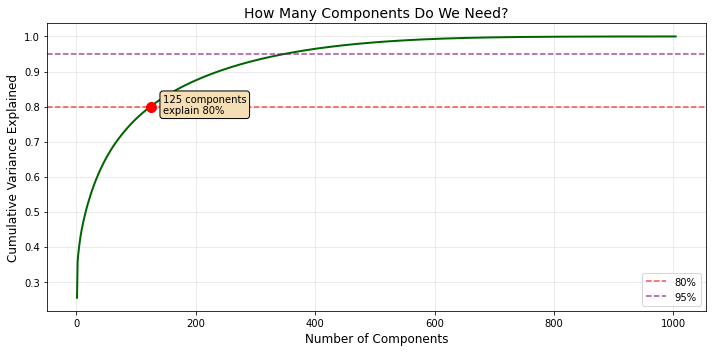

• 125 components capture 80% variance
• That's 1315 fewer features! (91% reduction)


In [10]:
# Plot cumulative variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumsum)+1), cumsum, linewidth=2, color='darkgreen')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Variance Explained', fontsize=12)
plt.title('How Many Components Do We Need?', fontsize=14)
plt.grid(True, alpha=0.3)

# Add reference lines
plt.axhline(0.8, color='red', linestyle='--', alpha=0.7, label='80%')
plt.axhline(0.95, color='purple', linestyle='--', alpha=0.7, label='95%')
plt.legend()

# Annotate 80% point
n_80 = np.argmax(cumsum >= 0.8) + 1
plt.plot(n_80, 0.8, 'ro', markersize=10)
plt.text(n_80+20, 0.78, f'{n_80} components\nexplain 80%', 
         fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

print(f"• {n_80} components capture 80% variance")
print(f"• That's {1440-n_80} fewer features! ({(1-(n_80/1440))*100:.0f}% reduction)")

## Finding Optimal Number of Components

**Best approach**: Use validation curves to find the number that gives best prediction performance!

In [11]:
# Create pipeline: PCA -> Ridge regression
pipeline_pca = Pipeline([
    ('pca', PCA()),
    ('ridge', Ridge(alpha=100))
])

# Test different numbers of components
n_components_range = np.arange(10, 510, 20).astype(int)

print("Testing different numbers of PCA components...")
print(f"Testing: {n_components_range[0]} to {n_components_range[-1]} components")
print("This will take 1-2 minutes...\n")

# Compute validation curve
train_scores, test_scores = validation_curve(
    pipeline_pca, X_all_scaled, y,
    param_name='pca__n_components',
    param_range=n_components_range,
    cv=5,
    scoring='r2'
)

# Calculate means
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

print("✓ Validation curve computed!\n")

# Find optimal number of components
best_idx = test_mean.argmax()
best_n = n_components_range[best_idx]
best_score = test_mean[best_idx]

print(f"Optimal number of components: {best_n}")
print(f"Best cross-validated R²: {best_score:.3f}")

Testing different numbers of PCA components...
Testing: 10 to 490 components
This will take 1-2 minutes...

✓ Validation curve computed!

Optimal number of components: 110
Best cross-validated R²: 0.673
✓ Validation curve computed!

Optimal number of components: 110
Best cross-validated R²: 0.673


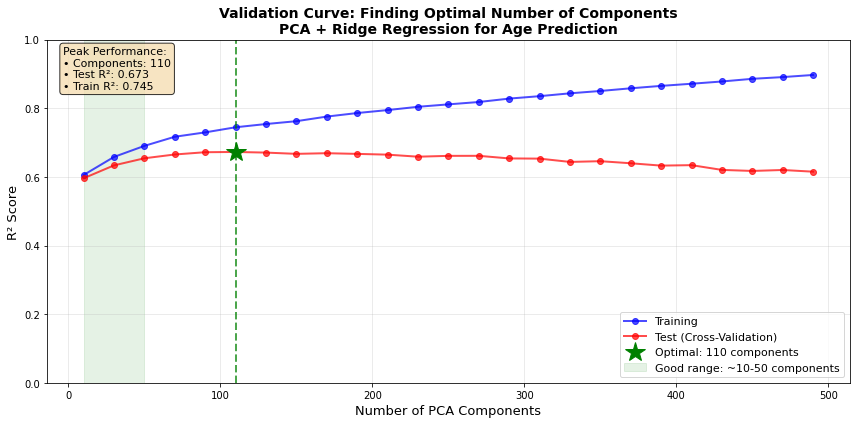

In [14]:
# Plot validation curve
plt.figure(figsize=(12, 6))

plt.plot(n_components_range, train_mean, 'o-', label='Training', 
         linewidth=2, markersize=6, color='blue', alpha=0.7)
plt.plot(n_components_range, test_mean, 'o-', label='Test (Cross-Validation)', 
         linewidth=2, markersize=6, color='red', alpha=0.7)

# Highlight optimal point
plt.axvline(best_n, color='green', linestyle='--', linewidth=2, alpha=0.7)
plt.plot(best_n, best_score, 'g*', markersize=20, label=f'Optimal: {best_n} components')

# Add shaded region for good performance
good_start = n_components_range[np.argmax(test_mean > 0.5)]
good_end = n_components_range[np.argmax(test_mean > best_score * 0.95)]
plt.axvspan(good_start, good_end, alpha=0.1, color='green', 
            label=f'Good range: ~{good_start}-{good_end} components')

plt.xlabel('Number of PCA Components', fontsize=13)
plt.ylabel('R² Score', fontsize=13)
plt.title('Validation Curve: Finding Optimal Number of Components\nPCA + Ridge Regression for Age Prediction', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Add annotation box
textstr = f'Peak Performance:\n• Components: {best_n}\n• Test R²: {best_score:.3f}\n• Train R²: {train_mean[best_idx]:.3f}'
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

**Key insight**: First 30-50 components capture most predictive information. That's a 97% reduction from 1,440 features!

## Summary

**Key Takeaways:**

1. **Dimensionality Reduction**: Reduce features while preserving information
   - Prevents overfitting
   - Improves computational efficiency
   - Increases signal-to-noise ratio

2. **PCA**: Creates new features by combining originals
   - Finds directions of maximum variance
   - First components capture most information
   - Components are linear combinations of features

3. **Practical Benefits**:
   - 110 PCA components can replace 1,440 features
   - 95%+ reduction with minimal information loss
   - Works especially well with correlated features

4. **Best Practices**:
   - Always standardize features first
   - Use validation curves to choose number of components
   - Consider interpretability trade-off